In [1]:
import pandas as pd
from pathlib import Path

a2_df_census_ol_pejeta_western = pd.read_pickle("../data/pkl/a2_df_census_ol_pejeta_western.pkl")
a2_df_census_ol_pejeta_western_rank = pd.read_pickle("../data/pkl/a2_df_census_ol_pejeta_western_rank.pkl")
a2_df_census_ol_pejeta_western_rank.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Acinonyx jubatus,16,14,18,17,18,18,19,22,17,17,19,21,16,20,16,18,17
Aepyceros melampus,3,2,2,2,2,2,2,2,2,3,2,1,3,2,3,3,1
Alcelaphus buselaphus,5,8,9,7,9,12,12,12,12,12,13,12,11,13,10,12,13
Bos taurus indicus,16,14,18,17,15,18,19,22,19,17,19,21,16,20,16,18,17
Canis mesomelas,13,14,18,17,14,18,15,18,16,14,19,15,16,15,16,14,17


In [2]:
import pandas as pd
import numpy as np

summary = a2_df_census_ol_pejeta_western.copy()

to_rank = (
    summary
    .drop(index="Column_Total", errors="ignore")
    .drop(columns=["Row_Total"], errors="ignore")
)

ranks_wide = to_rank.rank(axis=0, method='min', ascending=False)

# 1) Reciprocal-rank weights (higher rank -> smaller weight)
recip = (1 / ranks_wide).astype(float).fillna(0)

# 2) Normalize within each year so column weights sum to 1 (makes years comparable)
recip_norm = recip.div(recip.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)

# 3) A cross-year dominance score per species (equal weight to each year)
species_recip_score = recip_norm.mean(axis=1).sort_values(ascending=False)

# Optional: “Borda-like” linear rank weights, also normalised per year
max_rank_per_year = ranks_wide.max(skipna=True)
borda = (max_rank_per_year - ranks_wide + 1)  # top rank gets largest weight
borda_norm = borda.div(borda.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
species_borda_score = borda_norm.mean(axis=1).sort_values(ascending=False)

borda.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Acinonyx jubatus,1.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Aepyceros melampus,14.0,13.0,17.0,16.0,23.0,17.0,18.0,21.0,18.0,15.0,18.0,21.0,14.0,19.0,14.0,16.0,17.0
Alcelaphus buselaphus,12.0,7.0,10.0,11.0,16.0,7.0,8.0,11.0,8.0,6.0,7.0,10.0,6.0,8.0,7.0,7.0,5.0
Bos taurus indicus,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Canis mesomelas,4.0,1.0,1.0,1.0,11.0,1.0,5.0,5.0,4.0,4.0,1.0,7.0,1.0,6.0,1.0,5.0,1.0


In [3]:
species_borda_score.head(50)

Species
Equus burchellii             0.095950
Aepyceros melampus           0.090724
Syncerus caffer              0.083494
Eudorcas thomsonii           0.081561
Nanger granti                0.077674
Loxodonta africana           0.062785
Taurotragus oryx             0.061047
Giraffa camelopardalis       0.057322
Phacochoerus africanus       0.052635
Alcelaphus buselaphus        0.045383
Papio anubis                 0.043943
Kobus ellipsiprymnus         0.041647
Diceros bicornis             0.033251
Panthera leo                 0.023667
Canis mesomelas              0.016562
Equus                        0.015975
Equus grevyi                 0.014217
Ceratotherium simum simum    0.013555
Raphicerus campestris        0.013130
Oryx beisa                   0.009573
Crocuta                      0.009553
Erythrocebus patas           0.008968
Acinonyx jubatus             0.007204
Bos taurus indicus           0.007181
Lycaon pictus                0.006955
Redunca redunca              0.006856
Trag

In [5]:
# Proportional abundances per year
prop = to_rank.div(to_rank.sum(axis=0).replace(0, np.nan), axis=1)

# Shannon diversity H' and Pielou evenness J' per year
H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0)
S = (to_rank > 0).sum(axis=0)                    # richness
J = H / np.log(S.replace(0, np.nan))

# Bray–Curtis dissimilarity needs pairwise comparisons; Spearman rank corr for rank stability:
spearman_by_year = to_rank.corr(method='spearman')  # columns = years
prop.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Acinonyx jubatus,0.000000,0.000000,0.000000,0.000000,0.000452,0.000000,0.000000,0.000000,0.000306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aepyceros melampus,0.096354,0.088923,0.135683,0.247671,0.189866,0.204539,0.256613,0.217266,0.204525,0.192403,0.233601,0.239380,0.202712,0.232812,0.180859,0.197173,0.397290
Alcelaphus buselaphus,0.023624,0.026655,0.017544,0.013473,0.014930,0.007221,0.005010,0.003884,0.011006,0.004169,0.003798,0.005563,0.008335,0.003720,0.003378,0.003029,0.004517
Bos taurus indicus,0.000000,0.000000,0.000000,0.000000,0.000754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Canis mesomelas,0.000186,0.000000,0.000000,0.000000,0.001056,0.000000,0.000401,0.000125,0.000917,0.002316,0.000000,0.000506,0.000000,0.000770,0.000000,0.001731,0.000000


In [6]:
abund = a2_df_census_ol_pejeta_western

In [7]:
def diversity_metrics(abund: pd.DataFrame) -> pd.DataFrame:
    # proportions per year
    col_sums = abund.sum(axis=0)
    prop = abund.div(col_sums.replace(0, np.nan), axis=1)

    # richness (Hill N0)
    S = (abund > 0).sum(axis=0)

    # Shannon (H'), Hill N1 = exp(H')
    H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0).fillna(0)
    N1 = np.exp(H)

    # Simpson D = sum p^2, Hill N2 = 1/D
    D = (prop ** 2).sum(axis=0).fillna(0)
    N2 = (1 / D.replace(0, np.nan)).fillna(0)

    # Evenness: Pielou J' and Hill evenness (N1/S)
    J = (H / np.log(S.replace(0, np.nan))).fillna(0)
    E_hill = (N1 / S.replace(0, np.nan)).fillna(0)

    out = pd.DataFrame({
        "Richness_S": S,
        "Shannon_H'": H,
        "Hill_N1": N1,
        "Simpson_D": D,
        "Hill_N2": N2,
        "Pielou_J'": J,
        "Hill_evenness_N1_over_S": E_hill,
        "Total_Abundance": col_sums
    })
    out.index.name = "Year"
    return out

metrics = diversity_metrics(abund)
metrics.round(3).head(50)

,Richness_S,Shannon_H',Hill_N1,Simpson_D,Hill_N2,Pielou_J',Hill_evenness_N1_over_S,Total_Abundance
Year,,,,,,,,
2005,16,1.363,3.908,0.356,2.808,0.492,0.244,10752
2006,14,1.474,4.367,0.337,2.965,0.559,0.312,9154
2007,18,1.504,4.500,0.332,3.016,0.520,0.250,12426
2008,17,1.540,4.665,0.314,3.183,0.544,0.274,12024
2009,24,1.667,5.298,0.299,3.346,0.525,0.221,13262
2010,18,1.534,4.636,0.325,3.076,0.531,0.258,13572
2012,19,1.602,4.964,0.308,3.244,0.544,0.261,19960
2013,22,1.665,5.288,0.300,3.338,0.539,0.240,15962
2014,19,1.675,5.340,0.299,3.339,0.569,0.281,13084


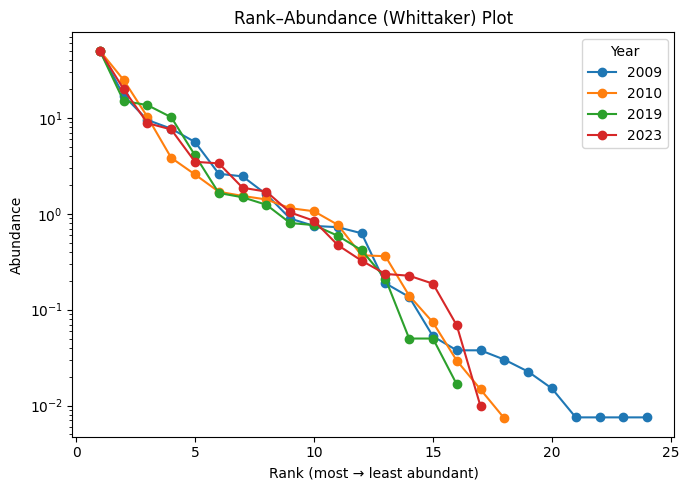

In [8]:
import matplotlib.pyplot as plt

def whittaker_plot(abund: pd.DataFrame, years=None, log_y=True):
    """
    Draws rank–abundance curves. One curve per year.
    """
    if years is None:
        years = list(abund.columns)

    plt.figure(figsize=(7, 5))
    for yr in years:
        s = abund[yr]
        s = s[s > 0].sort_values(ascending=False)  # positive abundances only
        if s.empty:
            continue
        ranks = np.arange(1, len(s) + 1)
        plt.plot(ranks, s.values, marker="o", label=str(yr))

    plt.xlabel("Rank (most → least abundant)")
    plt.ylabel("Abundance")
    if log_y:
        plt.yscale("log")  # classic Whittaker uses log-abundance
    plt.title("Rank–Abundance (Whittaker) Plot")
    plt.legend(title="Year")
    plt.tight_layout()
    plt.show()

# Example: plot a few years (or omit 'years=' to plot all)
#whittaker_plot(abund, years=[2005, 2009, 2017, 2023], log_y=True)
#whittaker_plot(prop*100, years=[2009, 2023], log_y=False)
#whittaker_plot(abund, years=[2008, 2019], log_y=True)
#whittaker_plot(abund, years=[2009, 2010, 2019, 2023], log_y=True)
prop = abund.div(abund.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
whittaker_plot(prop*100, years=[2009, 2010, 2019, 2023], log_y=True)